In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## 1 下载数据

In [2]:
from fastai.vision import *

In [3]:
# 设置数据路径
path = Config.data_path()/'planet'
path
path.as_posix()

PosixPath('/home/lyc/.fastai/data/planet')

'/home/lyc/.fastai/data/planet'

- 这里每个图片都会有多个标签

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
# 图片变换
# 关掉透视 max_wrap
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [6]:
# 构建数据集
np.random.seed(42)
# 使用 ImageList 是因为图像是多标签的
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

- 图像大小设置为 128

In [7]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [8]:
data

ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/lyc/.fastai/data/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/lyc/.fastai/data/planet;

Test: None

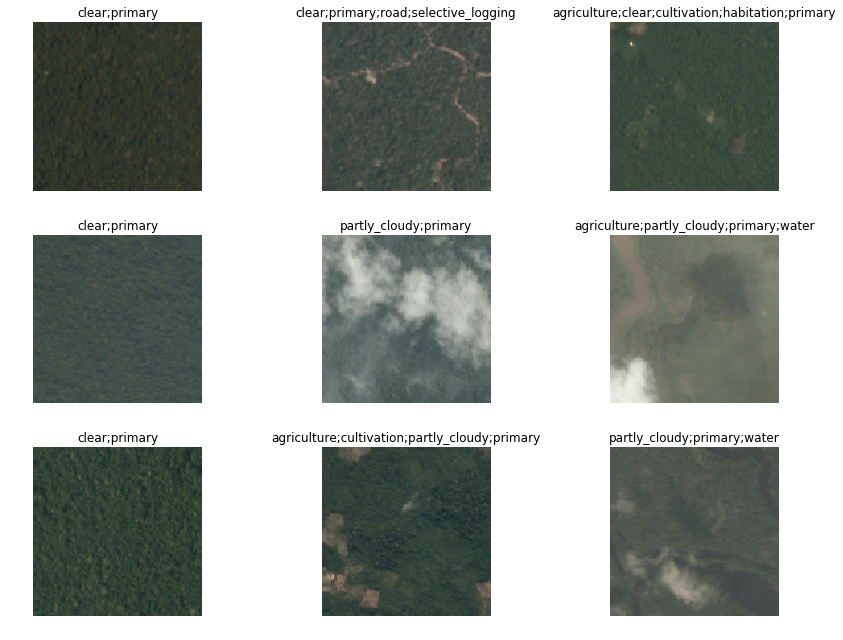

In [9]:
# 查看部分数据
data.show_batch(rows=3, figsize=(12,9))

- 分号分割了图形的不同类别信息

- 使用 阈值 作为预测标准，将大于阈值的预测结果与真实结果进行比较
- 使用 resnet50 作为模型
- 同时观察 F分数

In [10]:
# arch = models.resnet50
arch = models.resnet34  # 穷人

In [11]:
# 阈值设置为 0.2
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score02 = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score02])

- 寻找学习率

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


- 查看学习率情况并作出选择

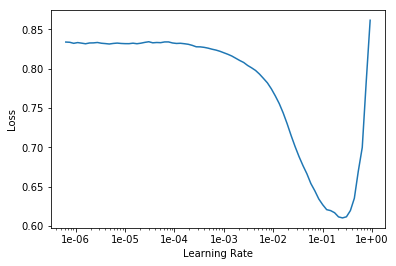

In [13]:
learn.recorder.plot()

- 根据上述图像，我们选择学习率为 0.01 Find the thing with the steepest slope 

In [14]:
lr = 0.01

- 训练模型

In [15]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.135254,0.118961,0.937979,0.894938,00:52
1,0.121224,0.103561,0.945217,0.909230,00:51
2,0.110501,0.105716,0.949460,0.903695,00:51
3,0.108711,0.099131,0.952280,0.914023,00:51
4,0.105675,0.093312,0.953094,0.918077,00:51
5,0.102907,0.092771,0.954220,0.920094,00:51
6,0.097741,0.090599,0.955535,0.920645,00:49
7,0.094619,0.088127,0.953239,0.923607,00:49
8,0.091608,0.087649,0.954365,0.923353,00:50
9,0.093216,0.087388,0.954903,0.923521,00:49


- 保存第一阶段的结果

In [16]:
learn.save('stage-1-rn50')

- unfreeze 并训练浅层网络的权重，微调过程

In [17]:
learn.unfreeze()

- 再次查找最佳学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


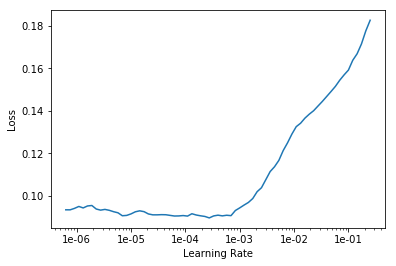

In [18]:
learn.lr_find()
learn.recorder.plot()

- 根据上述图，选择 lr1=1e-4
- 再次训练浅层网络并保存结果

In [19]:
lr1 = 1e-4
learn.fit_one_cycle(10, slice(lr1, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.099940,0.092671,0.950885,0.917816,00:58
1,0.103500,0.098629,0.948334,0.913520,00:58
2,0.098534,0.095712,0.953348,0.912435,00:58
3,0.095803,0.088999,0.949649,0.921507,00:58
4,0.091764,0.087697,0.956538,0.924196,00:58
5,0.088745,0.086715,0.959314,0.925645,00:58
6,0.085800,0.083977,0.956960,0.928144,00:58
7,0.082796,0.083269,0.958224,0.929402,00:58
8,0.081954,0.082919,0.959016,0.928458,00:58
9,0.080978,0.082379,0.958791,0.929013,00:59


In [20]:
learn.save('stage-2-rn50')
learn.export()

## 图像大小设置为 256

- 为了避免内存超出，这里将上述训练好的模型再次导入，并清理内存
- 仍旧使用之前的学习器，只是简单地更换数据
- Then I will freeze again (i.e. I'm going back to just training the last few layers) and I will do a new lr_find()

In [21]:
learn.load('stage-2-rn50');

In [22]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data

ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/lyc/.fastai/data/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/lyc/.fastai/data/planet;

Test: None

- 我们仍然使用之前定义的模型
- 再次训练之前，我们需要将浅层结构进行 freeze，不训练浅层结构的权重

In [23]:
learn.freeze()

- 寻找最佳学习率并再次训练

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


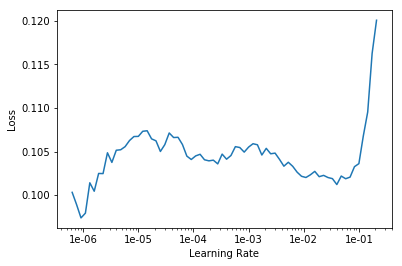

In [24]:
learn.lr_find()
learn.recorder.plot()
# 没钱买显卡，内存超出了

In [25]:
lr2=1e-3

In [26]:
learn.fit_one_cycle(10, slice(lr2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095802,0.091555,0.953973,0.920080,02:06
1,0.087496,0.086812,0.955019,0.925869,02:05
2,0.091371,0.085162,0.955267,0.926391,02:06
3,0.085818,0.084229,0.956604,0.926557,02:06
4,0.083872,0.083697,0.957011,0.928295,02:06
5,0.085426,0.083308,0.957955,0.928580,02:06
6,0.081555,0.083816,0.956393,0.927198,02:06
7,0.081699,0.082743,0.958079,0.928952,02:06
8,0.083981,0.082813,0.958827,0.929265,02:06
9,0.085018,0.082495,0.957999,0.929548,02:06


In [27]:
learn.save('stage-1-256-rn50')

- 继续进行第二阶段的微调

In [28]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


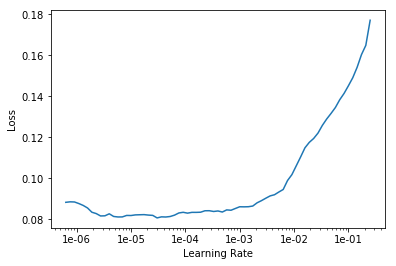

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
lr3 = 1e-4

In [31]:
learn.fit_one_cycle(10, slice(lr3, lr2/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085336,0.082664,0.958798,0.929768,02:47
1,0.084961,0.082358,0.956800,0.929465,02:47
2,0.084302,0.083963,0.958355,0.927583,02:47
3,0.083027,0.082652,0.957795,0.929133,02:47
4,0.084788,0.081678,0.957127,0.930079,02:46
5,0.079410,0.081487,0.957068,0.930033,02:47
6,0.078438,0.081064,0.958958,0.930365,02:47
7,0.078604,0.080470,0.958609,0.930833,02:47
8,0.077555,0.080476,0.959583,0.930857,02:47
9,0.075244,0.080617,0.958667,0.930577,02:47


- 查看训练损失

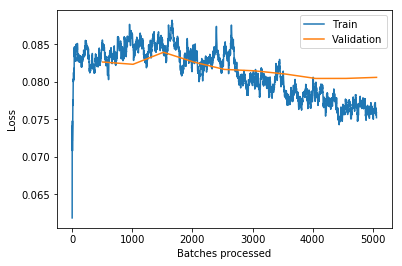

In [32]:
learn.recorder.plot_losses()

- 保存结果

In [33]:
learn.save('stage-2-256-rn50')

In [34]:
learn.export()

## 测试集

In [35]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

- 重新加载学习器

In [36]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [37]:
preds[:5]

tensor([[9.9642e-01, 1.1537e-06, 1.5298e-03, 2.1646e-05, 8.6779e-06, 8.5943e-01,
         1.1688e-04, 2.0228e-06, 1.2460e-01, 4.2248e-02, 5.1099e-02, 6.9181e-02,
         9.7037e-01, 9.4687e-01, 2.7331e-05, 3.7488e-04, 6.8113e-02],
        [1.4662e-02, 5.9561e-07, 1.2257e-04, 1.4832e-02, 4.9299e-04, 9.9914e-01,
         2.5366e-05, 4.9937e-06, 2.5061e-03, 7.2148e-03, 2.3289e-04, 6.7324e-04,
         9.9987e-01, 1.9098e-03, 1.7451e-03, 2.3856e-05, 6.4403e-03],
        [5.6921e-01, 3.6503e-04, 4.9448e-01, 4.4104e-05, 5.8525e-05, 9.4669e-01,
         6.1759e-04, 1.7965e-04, 2.8780e-02, 2.5915e-03, 4.4797e-02, 3.8414e-04,
         9.5782e-01, 3.0225e-02, 4.2598e-05, 1.7232e-03, 2.6884e-01],
        [7.6598e-01, 3.8834e-04, 1.3012e-02, 8.5999e-04, 1.0586e-03, 6.3710e-02,
         8.9973e-04, 7.4046e-04, 2.0846e-01, 5.6288e-02, 7.7736e-04, 9.4645e-01,
         9.9704e-01, 8.0468e-02, 1.7233e-03, 6.4144e-03, 8.9607e-01],
        [9.9955e-03, 2.8895e-06, 1.2104e-04, 2.5611e-01, 1.7034e-04, 9.9

In [38]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [39]:
labelled_preds[:5]

['agriculture clear primary road',
 'clear primary',
 'agriculture bare_ground clear primary water',
 'agriculture cultivation partly_cloudy primary water',
 'blooming clear primary']

In [40]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [41]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [42]:
df.to_csv(path/'submission.csv', index=False)

## 提交结果

In [43]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|███████████████████████████████████████| 2.21M/2.21M [00:16<00:00, 142kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

## 其他内容

- 对于数据我们关心
- 数据的存储路径
- 数据的结构
- labels 的格式
- 验证集划分
- 数据变换

- 数据集的创建

```python
data = (ImageFileList.from_folder(path)  # Where to find the data? -> in path and its subfolders
        .label_from_folder()             # How to label? -> depending on the folder of the filenames
        .split_by_folder()               # How to split in train/valid? -> use the folders
        .add_test_folder()               # Optionally add a test set
        .datasets()                      # How to convert to datasets?
        .transform(tfms, size=224)       # Data augmentation? -> use tfms with a size of 224
        .databunch())                    # Finally? -> use the defaults for conversion to ImageDataBunch
```

[notes/Lesson3.md at master · hiromis/notes](https://github.com/hiromis/notes/blob/master/Lesson3.md)

对于普通的图像，我们通常只做左右反转，因为我们不希望某个要识别的对象是颠倒的

但是对于卫星图像颠倒是一种有效的数据扩充方式，我们总是试图旋转所有的 90度

max_wrap 是fastai中提供的透视功能模块，主要是说：观察视角不同，在图像上方观察和图像下方观查会导致数据的不同，在猫狗识别等任务中透视功能是有效的，但是在卫星图像中，由于卫星拍摄总算从上到下的，我们不可能从下往上拍摄，所以要关掉透视

- metrics 只是用来衡量模型的表现与模型本身的训练方式无关
- And then for the second half of my slice, I normally do whatever learning rate are used for the the frozen part. So lr which was 0.01 kind of divided by five or ten. Somewhere around that. That's my rule of thumb